In [1]:
from behav3d.segmentation.ilastik_segmentation import run_ilastik_segmentation
from behav3d.tracking.trackmate_tracking import (
    run_trackmate_tcells, 
    run_trackmate_organoids
)
from behav3d.analysis.feature_extraction import (
    calculate_track_features,
    filter_tracks,
    summarize_track_features
)
from behav3d.analysis.tcell_analysis import run_tcell_analysis
import yaml
import pandas as pd

/Users/samdeblank/opt/anaconda3/envs/behav3d/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


<Figure size 100x100 with 0 Axes>

### Load in config and metadata csv
Make sure to edit the metadata .csv accordingly


BEHAV3D requires the input to be an .h5 file (image_path) with a 4D image in a specific internal path (image_internal_path)

When processing from the raw image, make sure to supply:
- image_path
- image_internal_path

BEHAV3D can work with custom preprocessing by doing the segmentation and tracking steps yourself and placing the results as .tiff (with specific sample naming in the output directory and supplying the tcell_tracks.csv containign the cell positions in the metadata .csv:
- the segmented t-cells (<sample_name>_tcells_tracked.tiff)
- segmented organoids (<sample_name>_organoids_tracked.tiff)
- "tcell_tracks.csv" in the metadata .csv


In [2]:
# Change this path to your config file
config_path = "/Users/samdeblank/Documents/1.projects/BHVD_BEHAV3D/BEHAV3D-ilastik/test/BEHAV3D_run/config.yml"

with open(config_path, "r") as parameters:
        config=yaml.load(parameters, Loader=yaml.SafeLoader)
metadata = pd.read_csv(config["metadata_csv_path"])
[print(f"{k}: {v}") for k,v in config.items()]
metadata

output_dir: /Users/samdeblank/Documents/1.projects/BHVD_BEHAV3D/BEHAV3D-ilastik/test/BEHAV3D_run/ilastik_output
metadata_csv_path: /Users/samdeblank/Documents/1.projects/BHVD_BEHAV3D/BEHAV3D-ilastik/test/BEHAV3D_run/metadata.csv
ilastik_path: /Applications/ilastik-1.4.0b27-OSX.app/Contents/ilastik-release/run_ilastik.sh
ilastik_pixel_classifier_model: /Users/samdeblank/Documents/1.projects/BHVD_BEHAV3D/BEHAV3D-ilastik/ilastik_pipelines/AIM_MB2_pixel_class.ilp
ilastik_organoid_segmentation_model: /Users/samdeblank/Documents/1.projects/BHVD_BEHAV3D/BEHAV3D-ilastik/ilastik_pipelines/AIM_MB2_organoid_class.ilp
ilastik_tcell_segmentation_model: /Users/samdeblank/Documents/1.projects/BHVD_BEHAV3D/BEHAV3D-ilastik/ilastik_pipelines/AIM_MB2_tcell_class.ilp
ilastik_organoid_postprocessing_model: /Users/samdeblank/Documents/1.projects/BHVD_BEHAV3D/BEHAV3D-ilastik/ilastik_pipelines/AIM_MB2_object_splitter.ilp
ilastik_tcell_postprocessing_model: /Users/samdeblank/Documents/1.projects/BHVD_BEHAV3D/B

,sample_name,organoid_line,tcell_line,exp_nr,well,dead_dye_channel,dead_dye_threshold,contact_threshold,pixel_distance_xy,pixel_distance_z,distance_unit,time_interval,time_unit,image_path,image_internal_path,tcell_track_csv
0,AIM_MB2_Exp58_Img003_donor899,10T,CART_WT1,1,well0,3,3000,3.6,1.38,1.38,μm,2,m,/Users/samdeblank/Documents/1.projects/BHVD_BE...,/image,/Users/samdeblank/Documents/1.projects/BHVD_BE...


### Performing ilastik segmentation
Uses the pretrained supplied ilastik models for pixel classification, object detection and object postprocessing (object splitting) for both T cells and Organoids/Tumor cells

In [ ]:
run_ilastik_segmentation(config, metadata, verbose=False)

### Performing TrackMate tracking
Applies TrackMate for the tracking of the T cells and organoids/tumor cells over all timepoints

In [ ]:
run_trackmate_tcells(config, metadata, verbose=False)
run_trackmate_organoids(config, metadata, verbose=False)

### Calculate the track features, filter tracks and summarize track features

**calculate_track_features** <br>
Calculates movement, contact and intensity features for each timepoint in all tracks per experiment

**filter_tracks** <br>
Filter out tracks based on:
- Maximum experiment length (tcell_exp_duration)    
- Minimum track length (tcell_min_track_length)
- Tracks starting at timepoint 1 with a dead dye mean over the dead_dye_threshold (dead_dye_threshold)

Additonally, all tracks are cut down to:
- Maximum track length (tcell_max_track_length)

**summarize track features** <br>
Summarizes the features into one value for each TrackID per experiment



--------------- Processing tcells: AIM_MB2_Exp58_Img003_donor899 ---------------
###### Running track feature calculation
- Loading in tracks csv...
- Calculating contact with organoids and other T cells...
Using a contact threshold of 3.6μm
- Calculating death dye intensities...
- Interpolating missing timepoints based on time interval
- Calculating cell death based on defined dead_dye_threshold 3000
- Converting distance and time unit to default µm and hours...
- Calculating movement features...
- Determining active contact of T cells
- Perform z-normalization on selected feature columns
- Writing output to /Users/samdeblank/Documents/1.projects/BHVD_BEHAV3D/BEHAV3D-ilastik/test/BEHAV3D_run/ilastik_output/AIM_MB2_Exp58_Img003_donor899_tcells_track_features.csv
### DONE - elapsed time: 0:16:45

--------------- Filtering tracks ---------------


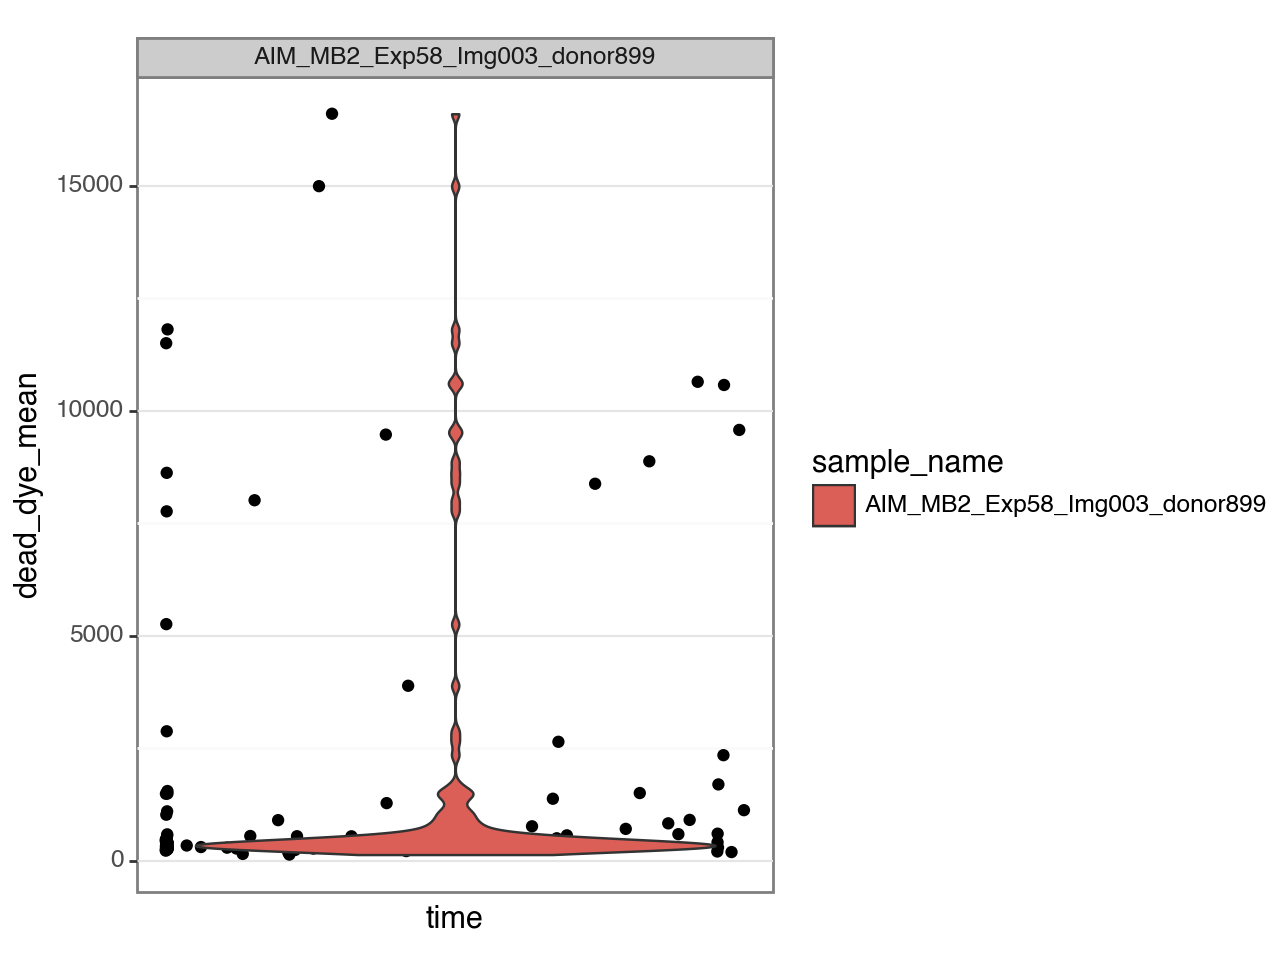

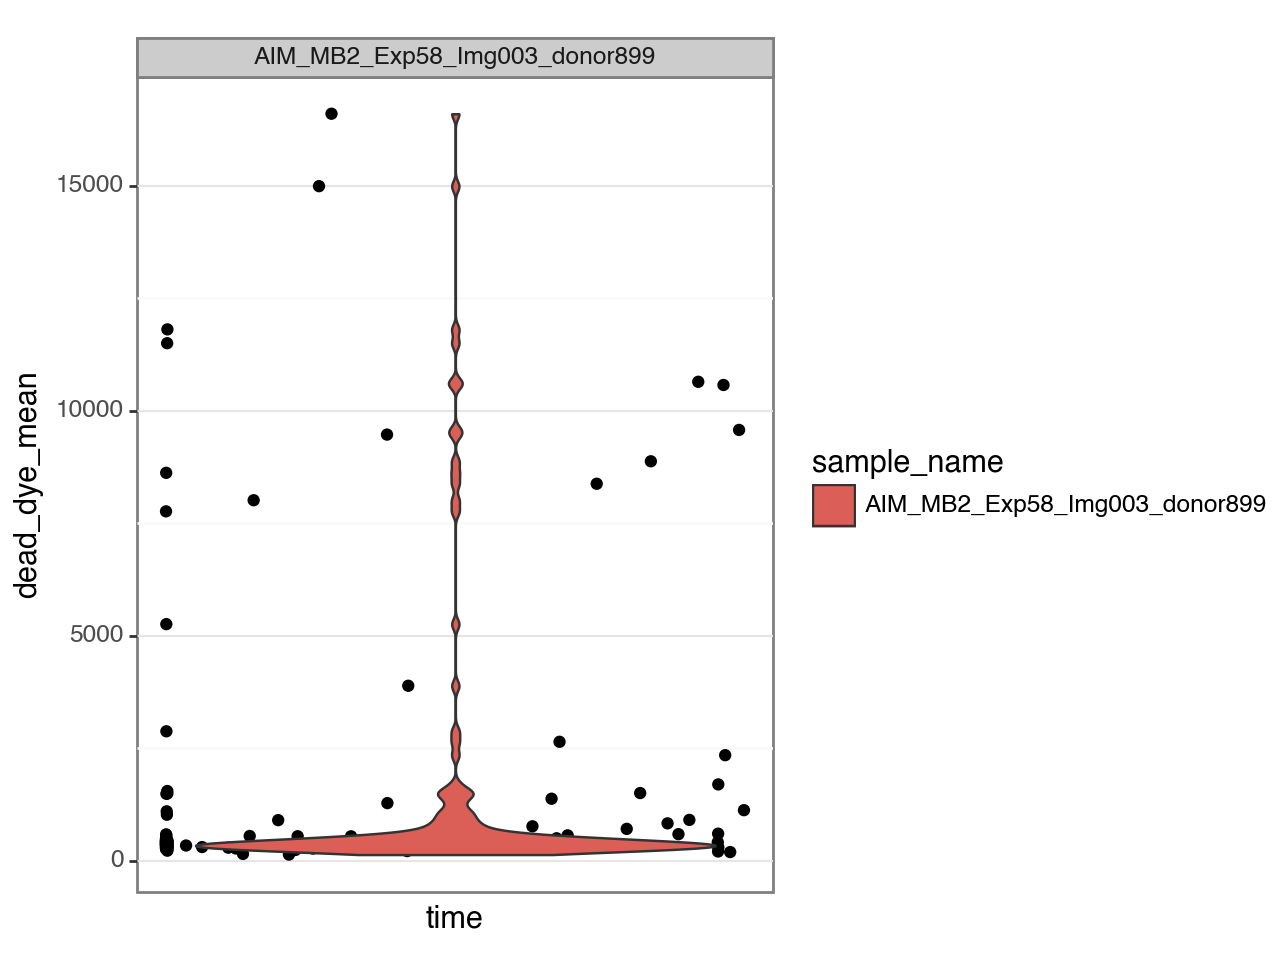


- Writing filtered tracks to /Users/samdeblank/Documents/1.projects/BHVD_BEHAV3D/BEHAV3D-ilastik/test/BEHAV3D_run/ilastik_output/BEHAV3D_combined_track_features_filtered.csv
### DONE - elapsed time: 0:00:04

--------------- Summarizing track features ---------------
- Writing summarized tracks to /Users/samdeblank/Documents/1.projects/BHVD_BEHAV3D/BEHAV3D-ilastik/test/BEHAV3D_run/ilastik_output/BEHAV3D_combined_track_features_summarized.csv
### DONE - elapsed time: 0:00:00



In [3]:
df_tracks = calculate_track_features(config, metadata, cell_type="tcells")
df_tracks_filt = filter_tracks(df_tracks, config, metadata)
df_tracks_summ = summarize_track_features(df_tracks_filt, config)

In [ ]:
df_tracks = calculate_track_features(config, metadata, cell_type="organoids")

### Perform data analysis

In [3]:
df_tracks_clustered = run_tcell_analysis(config)

Set 'tcell_min_track_length' and 'tcell_max_track_length' to the same value to create equal tracks
- Calculating the dynamic time warping distance matrix
- Fitting the dynamic time warping to a UMAP


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


- Performing clustering on the UMAP data
- Writing clustered tracks to /Users/samdeblank/Documents/1.projects/BHVD_BEHAV3D/BEHAV3D-ilastik/test/BEHAV3D_run/ilastik_output/BEHAV3D_UMAP_clusters.csv
- Producing clustered UMAP plots with displayed Track features
- Producing heatmaps with summarized cluster features
- Producing percentage plots of each cluster per combination of T-cell and organoid line
- Writing summarized tracks to /Users/samdeblank/Documents/1.projects/BHVD_BEHAV3D/BEHAV3D-ilastik/test/BEHAV3D_run/ilastik_output/BEHAV3D_UMAP_cluster_percentages.csv
